## Import the Model

In [12]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.python.keras.applications.vgg19 import VGG19

In [13]:
model = VGG19(include_top = False,
             weights = 'imagenet')
model.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Import Libraries and Helper Functions

In [14]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [15]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    
    return img

In [19]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

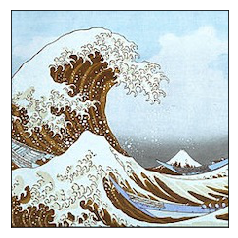

In [20]:
display_image(load_and_process_image('style.jpg'))

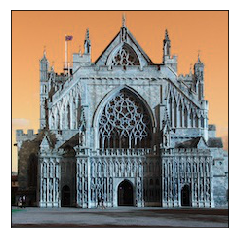

In [21]:
display_image(load_and_process_image('content.jpg'))

## Content and Style Models

In [23]:
content_layer = 'block5_conv2'

style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                      outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [24]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

## Gram Matrix

In [32]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a = True)
    return G / tf.cast(n, tf.float32)

## Style Cost

In [33]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
        
    return J_style

## Training Loop

In [36]:
import time
generated_images= []

def training_loop(content_path, style_path, iterations = 20,
                 alpha = 10, beta = 20):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate = 7.)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content + beta * J_style
            
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time.time() - start_time))
        generated_images.append(generated.numpy())
        
    return best_image

In [37]:
best_image = training_loop('content.jpg','style.jpg')

Cost at 0: 13733912576.0. Time elapsed: 29.18790912628174
Cost at 1: 8505463296.0. Time elapsed: 58.367823123931885
Cost at 2: 5336516096.0. Time elapsed: 87.27174139022827
Cost at 3: 4128592640.0. Time elapsed: 116.38966798782349
Cost at 4: 3317655296.0. Time elapsed: 145.5775797367096
Cost at 5: 2790103808.0. Time elapsed: 175.32247042655945
Cost at 6: 2499503616.0. Time elapsed: 205.14135456085205
Cost at 7: 2265037056.0. Time elapsed: 235.22424602508545
Cost at 8: 2034322048.0. Time elapsed: 265.04312682151794
Cost at 9: 1824459136.0. Time elapsed: 294.1680417060852
Cost at 10: 1640854528.0. Time elapsed: 324.0399327278137
Cost at 11: 1471670400.0. Time elapsed: 354.61779022216797
Cost at 12: 1319436416.0. Time elapsed: 387.0155863761902
Cost at 13: 1195413888.0. Time elapsed: 417.7164394855499
Cost at 14: 1099801216.0. Time elapsed: 448.3932945728302
Cost at 15: 1021752448.0. Time elapsed: 479.8161244392395
Cost at 16: 954208064.0. Time elapsed: 511.81693625450134
Cost at 17: 8929

## Plot the Results

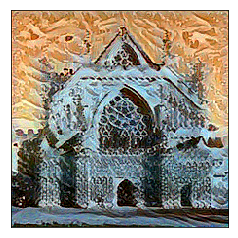

In [38]:
display_image(best_image)

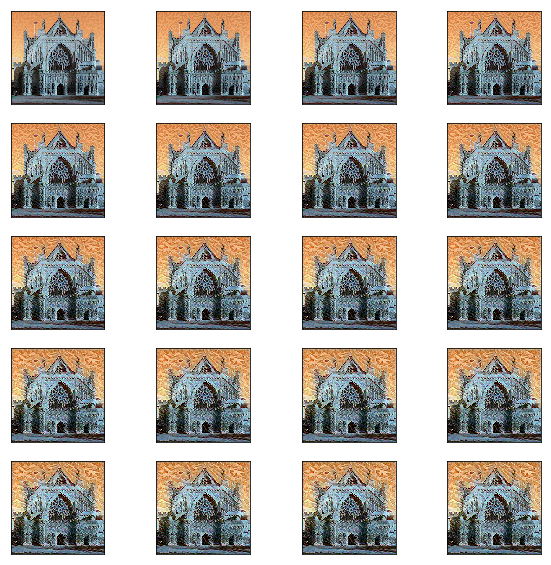

In [39]:
plt.figure(figsize = (10,10))

for i in range(20):
    plt.subplot(5,4,i+1)
    display_image(generated_images[i])
    
plt.show()